## 🧱 CELL 1 – Imports, config et utilitaires

In [1]:
# --- CELL 1: Imports & setup ---
import os, math, time, random, json, gc
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True

SEED = 2025
random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def free_gpu():
    if torch.cuda.is_available():
        torch.cuda.empty_cache(); gc.collect()

# Contrôle global de la version du notebook
USE_LORA = False   # <---- Option B = True plus tard
print(f"Device: {device} | USE_LORA = {USE_LORA}")


Device: cuda | USE_LORA = False


## 🧱 CELL 2 – Charger UNI-2h (timm) + transform

In [2]:
# --- CELL 2: UNI-2h loader (timm) + transform ---
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

timm_kwargs = dict(
    img_size=224, patch_size=14, depth=24, num_heads=24, embed_dim=1536,
    mlp_ratio=2.66667 * 2, in_chans=3, num_classes=0,
)

uni = timm.create_model("vit_large_patch14_224", pretrained=False, **timm_kwargs)
# Chargement de ton checkpoint pré-entraîné UNI-2h ici si disponible :
# state = torch.load("/workspace/checkpoints/uni2h.pth", map_location="cpu")
# uni.load_state_dict(state, strict=False)

uni.eval().to(device)
for p in uni.parameters():
    p.requires_grad_(False)

cfg = resolve_data_config({}, model=uni)
tfm = create_transform(**cfg)

@torch.inference_mode()
def uni_embed_from_tensor(x_3chw: torch.Tensor) -> torch.Tensor:
    e = uni(x_3chw)
    if e.ndim == 3:
        e = e[:, 0]  # token [CLS]
    return e  # [B,1536]

print("✅ UNI-2h prêt. Embedding dim = 1536")


✅ UNI-2h prêt. Embedding dim = 1536


### 🧱 CELL 3 – Vérification rapide UNI-2h

In [3]:
# --- CELL 3: Sanity check UNI ---
x = torch.randn(1, 3, 224, 224, device=device)
with torch.inference_mode():
    e = uni_embed_from_tensor(x)
print("UNI embedding:", e.shape)


UNI embedding: torch.Size([1, 1536])


## 🧱 CELL 4 – Charger PixCell-256 + VAE + monkey-patch

In [4]:
# --- CELL 4: VAE SD3.5 + PixCell-256 + monkey-patch ---
# --- Recharge PixCell avec son code "custom_pipeline" complet ---
from diffusers import DiffusionPipeline
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(
    "stabilityai/stable-diffusion-3.5-large",
    subfolder="vae",
    torch_dtype=torch.float16,
)

pipe256 = DiffusionPipeline.from_pretrained(
    "StonyBrook-CVLab/PixCell-256",
    vae=vae,
    custom_pipeline="StonyBrook-CVLab/PixCell-pipeline",  # ⚠️ ceci charge le code conditionnel
    trust_remote_code=True,
    torch_dtype=torch.float16,
).to(device)

print("✅ Pipeline PixCell rechargée avec code custom")

# Monkey-patch: robustification de PixArtAlphaCombinedTimestepSizeEmbeddings.forward
import types
adaln   = pipe256.transformer.adaln_single
emb_mod = adaln.emb
_orig_forward = emb_mod.forward

def _patched_forward(self, *f_args, **f_kwargs):
    import torch
    timestep = f_args[0] if len(f_args)>0 else f_kwargs.get("timestep")
    resolution   = f_kwargs.get("resolution")
    aspect_ratio = f_kwargs.get("aspect_ratio")
    if resolution is None and len(f_args)>1:   resolution   = f_args[1]
    if aspect_ratio is None and len(f_args)>2: aspect_ratio = f_args[2]
    batch_size   = f_kwargs.get("batch_size")
    hidden_dtype = f_kwargs.get("hidden_dtype")
    if batch_size is None and len(f_args)>3:   batch_size   = f_args[3]
    if hidden_dtype is None and len(f_args)>4: hidden_dtype = f_args[4]

    if batch_size is not None:
        B = int(batch_size.item()) if isinstance(batch_size, torch.Tensor) else int(batch_size)
    else:
        B = len(timestep) if isinstance(timestep, torch.Tensor) else 1

    dev = timestep.device if isinstance(timestep, torch.Tensor) else next(self.parameters()).device
    if resolution is None:
        resolution = torch.full((B,), 256.0, device=dev, dtype=torch.float32)
    if aspect_ratio is None:
        aspect_ratio = torch.full((B,), 1.0, device=dev, dtype=torch.float32)

    return _orig_forward(
        timestep, resolution, aspect_ratio,
        batch_size=batch_size, hidden_dtype=hidden_dtype
    )

emb_mod.forward = types.MethodType(_patched_forward, emb_mod)
print("✅ Monkey-patch PixArt embeddings OK")


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Keyword arguments {'trust_remote_code': True} are not expected by PixCellPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

The config attributes {'double_self_attention': False, 'num_vector_embeds': None, 'only_cross_attention': False, 'use_linear_projection': False} were passed to PixCellTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'flow_shift': 1.0, 'use_flow_sigmas': False} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


✅ Pipeline PixCell rechargée avec code custom
✅ Monkey-patch PixArt embeddings OK


### Hook de conditionnement intégré dans le Pipeline PixCell

In [5]:
# === CELLULE : Installation d'un hook de conditionnement dans le pipeline PixCell ===
import torch, types
import torch.nn.functional as F

def install_uni_conditioning_hook(pipe, alpha=1.5):
    """
    Installe un forward_pre_hook sur pipe.transformer pour injecter UNI (1536-D) 
    comme biais additif dans hidden_states AVANT le forward du transformer.
    - alpha: intensité du conditionnement (augmente si c'est trop timide)
    """
    tr = pipe.transformer

    # Nettoyage si déjà installé
    if hasattr(tr, "_uni_hook_handle"):
        tr._uni_hook_handle.remove()
        delattr(tr, "_uni_hook_handle")
    if hasattr(tr, "_uni_proj"):
        delattr(tr, "_uni_proj")
    pipe._uni_alpha = float(alpha)  # mémorise l'intensité sur le pipe

    def _pre_hook(module, inputs):
        """
        inputs: tuple(args) passés à transformer.forward
          généralement (hidden_states, encoder_hidden_states=..., temb=..., ...)
        On modifie hidden_states = inputs[0] en y ajoutant proj(UNI).
        """
        if not hasattr(pipe, "_uni_cond") or (pipe._uni_cond is None):
            return  # pas de condition → on ne change rien

        # 1) Récupère hidden_states et UNI
        # inputs est un tuple immuable → on va reconstruire un nouveau tuple
        hidden_states = inputs[0]                     # [B,C,H,W]
        uni = pipe._uni_cond                          # [B,1,1536] fp16/32
        # Consommation one-shot
        pipe._uni_cond = None

        # 2) Prépare UNI et proj
        u = uni.squeeze(1).to(hidden_states.device)   # [B,1536]
        u = u.float()
        u = F.normalize(u, dim=-1)

        B, C, H, W = hidden_states.shape
        # Crée la projection si nécessaire: 1536 -> C
        if not hasattr(module, "_uni_proj"):
            module._uni_proj = torch.nn.Linear(1536, C, bias=False).to(hidden_states.device)
            torch.nn.init.orthogonal_(module._uni_proj.weight)

        cond = module._uni_proj(u)                    # [B,C]
        cond = cond.to(dtype=hidden_states.dtype).unsqueeze(-1).unsqueeze(-1)  # [B,C,1,1]

        # 3) Injection (additive) avant le forward
        hidden_states = hidden_states + pipe._uni_alpha * cond

        # 4) Reconstruis le tuple d'inputs avec le hidden_states modifié
        new_inputs = (hidden_states, ) + inputs[1:]
        return new_inputs  # retourner un tuple → remplace les args du forward

    # On installe le hook
    tr._uni_hook_handle = tr.register_forward_pre_hook(_pre_hook, with_kwargs=False)
    print(f"✅ Hook de conditionnement UNI installé (alpha={alpha}).")

def remove_uni_conditioning_hook(pipe):
    tr = pipe.transformer
    if hasattr(tr, "_uni_hook_handle"):
        tr._uni_hook_handle.remove()
        delattr(tr, "_uni_hook_handle")
        print("↩️ Hook de conditionnement retiré.")
    if hasattr(tr, "_uni_proj"):
        delattr(tr, "_uni_proj")
    if hasattr(pipe, "_uni_alpha"):
        delattr(pipe, "_uni_alpha")
    if hasattr(pipe, "_uni_cond"):
        delattr(pipe, "_uni_cond")



### Activation du hook

In [6]:
install_uni_conditioning_hook(pipe256, alpha=1.8)  # n’hésite pas à tester 1.5 → 2.5

✅ Hook de conditionnement UNI installé (alpha=1.8).


## 🧱 CELL 5 – Adapter UNI → c_dim + support futur pour LoRA

In [7]:
# --- CELL 5: Adapter UNI->c_dim + (préparation LoRA éventuelle) ---
C_DIM = 128  # condition dimension
ADAPTER_LR = 1e-4
LORA_LR    = 5e-5

class PixCellAdapter(nn.Module):
    def __init__(self, in_dim=1536, c_dim=C_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 1024), nn.SiLU(),
            nn.Linear(1024, c_dim)
        )
    def forward(self, e):
        return self.net(e)

ADAPTER = PixCellAdapter().to(device)

# --- Option B (LoRA) : définition du wrapper et injection différée ---
class LoRALinear(nn.Module):
    def __init__(self, base: nn.Linear, r=8, alpha=None):
        super().__init__()
        self.base = base
        self.r = r
        self.alpha = alpha or r
        self.A = nn.Parameter(torch.zeros(r, base.in_features))
        self.B = nn.Parameter(torch.zeros(base.out_features, r))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)
        for p in self.base.parameters():
            p.requires_grad_(False)

    def forward(self, x):
        out = self.base(x)
        delta = F.linear(x, self.A)
        delta = F.linear(delta, self.B) * (self.alpha / self.r)
        return out + delta

def inject_lora_into_pixcell(pipe, ranks=(8,), blocks_to_patch=None):
    """Injecte LoRA sur les derniers blocs d'attention de PixCell."""
    ranks = ranks if isinstance(ranks, (list, tuple)) else [ranks]
    params = []
    blocks = pipe.transformer.blocks
    if blocks_to_patch is None:
        blocks_to_patch = {len(blocks)-3, len(blocks)-1}
    for i, blk in enumerate(blocks):
        if i in blocks_to_patch:
            attn = blk.attn
            attn.to_q = LoRALinear(attn.to_q, r=ranks[0], alpha=ranks[0]).to(device)
            attn.to_v = LoRALinear(attn.to_v, r=ranks[0], alpha=ranks[0]).to(device)
            params += [attn.to_q.A, attn.to_q.B, attn.to_v.A, attn.to_v.B]
    return params

# --- Geler PixCell (sera partiellement dégelé si LoRA) ---
for name, sub in pipe256.components.items():
    if hasattr(sub, "parameters"):
        for p in sub.parameters():
            p.requires_grad_(False)

LORA_PARAMS = []
if USE_LORA:
    LORA_PARAMS = inject_lora_into_pixcell(pipe256, ranks=8)
    print(f"✅ LoRA injecté ({len(LORA_PARAMS)} tensors)")
else:
    print("✅ PixCell gelé (Option A active)")

print(f"Adapter params: {sum(p.numel() for p in ADAPTER.parameters())/1e6:.2f} M")



✅ PixCell gelé (Option A active)
Adapter params: 1.71 M


## 🧱 CELL 6 — Helpers d’inférence (préparation + génération)

In [8]:
# --- CELL 6: Préparation des entrées PixCell + génération ---
from PIL import Image
import numpy as np

@torch.inference_mode()
def prepare_pixcell256_inputs(images_3chw: torch.Tensor):
    """
    Encode un batch d'images via UNI-2h, puis projette via ADAPTER pour conditionner PixCell.
    images_3chw: torch.Tensor [B,3,H,W] pré-traitées (normalisées pour UNI)
    """
    B = images_3chw.size(0)
    # 1️⃣ embeddings UNI
    emb = uni_embed_from_tensor(images_3chw.to(device))   # [B,1536] fp32
    # 2️⃣ passage par l'adapter
    cond = ADAPTER(emb)                                   # [B,C_DIM]
    # 3️⃣ embeddings unconditional (zeros)
    uncond = torch.zeros_like(emb)                        # [B,1536]
    # 4️⃣ mise au format pipeline (PixCell attend [B,1,1536])
    return dict(emb=emb[:, None, :], uncond=uncond[:, None, :], cond=cond)

def run_pixcell256(embeds: torch.Tensor, uncond: torch.Tensor, 
                   guidance_scale=1.5, steps=20, n=1, seed=None, verbose=True):
    """
    Génération d’images via PixCell-256, conditionnée par les embeddings UNI/Adapter.
    - embeds: [B,1,1536]
    - uncond: [B,1,1536]
    """
    if seed is not None:
        torch.manual_seed(seed); np.random.seed(seed)

    B = embeds.shape[0]
    outs_imgs = []
    for k in range(B):
        if verbose:
            print(f" → Génération {k+1}/{B}")
        out = pipe256(
            num_inference_steps=steps,
            guidance_scale=guidance_scale,
            num_images_per_prompt=n,
            height=256, width=256,
            output_type="pil",
            return_dict=True,
            uni_embeds=embeds[k:k+1].half(),          # conditionnées
            negative_uni_embeds=uncond[k:k+1].half(), # unconditional
        ).images
        outs_imgs.append(out[0])
    return outs_imgs


### ✅ Exemple de test rapide

{'emb': torch.Size([1, 1, 1536]), 'uncond': torch.Size([1, 1, 1536]), 'cond': torch.Size([1, 128])}


  0%|          | 0/4 [00:00<?, ?it/s]

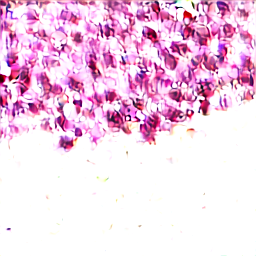

In [9]:
# Test minimal
x = torch.randn(1, 3, 224, 224)  # image bidon
inputs = prepare_pixcell256_inputs(x)
print({k: v.shape for k, v in inputs.items()})
outs = run_pixcell256(inputs["emb"], inputs["uncond"], steps=4, n=1, verbose=False)
outs[0].show()


## 🧱 CELL 7 — Construction de la banque d’embeddings UNI + prototypes par classe

In [10]:
# --- CELL 7: Cache des embeddings UNI et prototypes µ_k ---
from collections import defaultdict
from tqdm.notebook import tqdm

@torch.inference_mode()
def cache_uni_embeddings(dataloader, max_per_class=500):
    """
    Parcourt le dataloader et extrait jusqu’à `max_per_class` embeddings UNI par classe.
    Retourne un dict {class_id: tensor [N,1536]}.
    """
    bank = defaultdict(list)
    for x, y in tqdm(dataloader, desc="Caching UNI embeddings"):
        x = x.to(device)
        e = uni_embed_from_tensor(x)  # [B,1536]
        for ei, yi in zip(e, y):
            c = int(yi)
            if len(bank[c]) < max_per_class:
                bank[c].append(ei.cpu())
    bank = {c: torch.stack(v) for c, v in bank.items() if len(v)}
    print(f"✅ Embeddings stockés pour {len(bank)} classes.")
    return bank


def class_prototypes(bank, mode="mean"):
    """
    Calcule un prototype µ_k pour chaque classe dans la banque.
    mode='mean' ou 'medoid' (plus robuste aux outliers).
    """
    protos = {}
    for c, E in bank.items():  # E: [N,1536]
        if mode == "mean":
            protos[c] = E.mean(0)
        elif mode == "medoid":
            D = torch.cdist(E, E)
            protos[c] = E[D.sum(1).argmin()]
        else:
            raise ValueError("mode doit être 'mean' ou 'medoid'")
    PROTOS = torch.stack([protos[c] for c in sorted(protos)]).to(device)  # [K,1536]
    print(f"✅ {len(protos)} prototypes calculés ({mode})")
    return PROTOS


### 🧩 Exemple d’utilisation

In [11]:
# Exemple (à adapter à ton DataLoader)
# Chaque batch du dataloader doit renvoyer (x, y)
# x: torch.Tensor [B,3,H,W]
# y: torch.Tensor [B] avec les indices de classes

# BANK = cache_uni_embeddings(train_loader, max_per_class=300)
# PROTOS = class_prototypes(BANK, mode="mean")

# Visualisation rapide
# print("Shape des prototypes:", PROTOS.shape)

### 🔍 Visualisation de la structure des embeddings

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_uni_pca(bank, n_per_class=100):
    all_e, all_y = [], []
    for c, E in bank.items():
        all_e.append(E[:n_per_class])
        all_y.extend([c] * min(len(E), n_per_class))
    X = torch.cat(all_e).numpy()
    Y = np.array(all_y)
    Xp = PCA(2).fit_transform(X)
    plt.figure(figsize=(6,6))
    for c in sorted(set(Y)):
        plt.scatter(Xp[Y==c,0], Xp[Y==c,1], s=8, label=f"Class {c}")
    plt.legend(); plt.title("PCA des embeddings UNI-2h"); plt.show()

# plot_uni_pca(BANK)


## 🧱 CELL 8 — Chargement du dataset et DataLoader

✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (30 images / classe).
✅ Dataset chargé (270 images) | 9 classes
Classes: {'ADI': 10407, 'BACK': 10566, 'DEB': 11512, 'LYM': 11557, 'MUC': 8896} ...


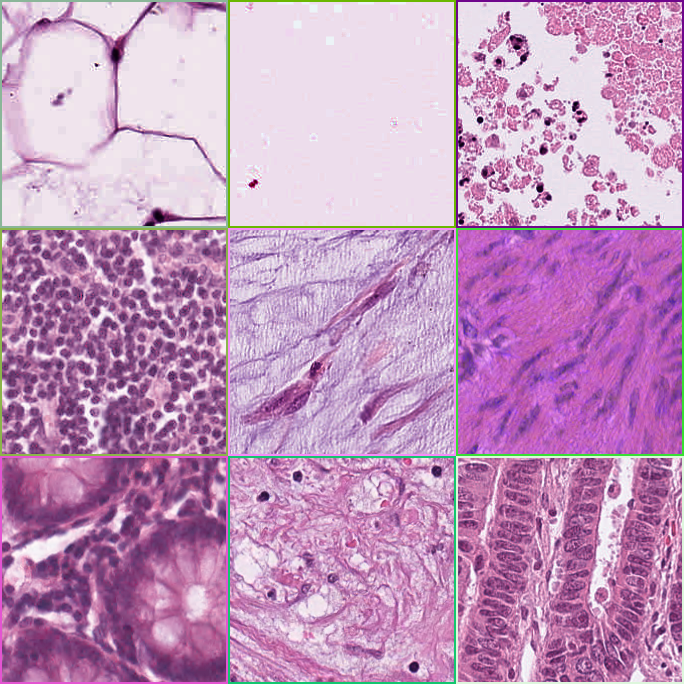

In [13]:
# --- CELL 8 (corrigée): Chargement du dataset + DataLoader depuis p9dg ---
import sys, os
from pathlib import Path
from torch.utils.data import DataLoader

# === Dossiers de travail ===
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "/workspace")).resolve()
DATA_DIR     = PROJECT_ROOT / "data"
CONFIG_DIR   = PROJECT_ROOT / "configs"
OUTPUT_DIR   = PROJECT_ROOT / "outputs"
P9DG_DIR     = PROJECT_ROOT / "p9dg"        # <--- datagenerator ici

for sub in ["cache_uni", "samples", "adapters", "logs"]:
    (OUTPUT_DIR / sub).mkdir(parents=True, exist_ok=True)

os.environ["CONFIG_DIR"] = str(CONFIG_DIR)  # utilisé par HistoDataset

# === Import du module depuis p9dg ===
if str(P9DG_DIR) not in sys.path:
    sys.path.append(str(P9DG_DIR))

try:
    from histo_dataset import HistoDataset, BalancedRoundRobinSampler
except Exception as e:
    raise ImportError(f"Impossible d'importer histo_dataset.py depuis {P9DG_DIR}: {e}")

# === Dataset : config “rapide” pour tests initiaux ===
train_ds = HistoDataset(
    root_data=str(DATA_DIR),
    split="train",
    output_size=224,             # entrée UNI = 224
    pixel_range="0_1",           # UNI attend [0,1]
    balance_per_class=True,
    samples_per_class_per_epoch=30,  # petit cache rapide ; augmente après
    apply_quality_filter=True,
    vahadane_enable=False,       # réactive après validation du flux
)

print(f"✅ Dataset chargé ({len(train_ds)} images) | {len(train_ds.class_to_idx)} classes")
print("Classes:", {k: v for k, v in list(train_ds.class_counts().items())[:5]}, "...")

# === DataLoader équilibré ===
sampler = BalancedRoundRobinSampler(train_ds)
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    sampler=sampler,
    num_workers=0,        # ⚙️ PAS DE MULTIPROCESSING
    pin_memory=False,     # ⚙️ DÉSACTIVÉ car inutile ici
)

# === Visualisation rapide (optionnelle) ===
try:
    grid = train_ds.vis(16)
    grid.show()  # sous Jupyter, ça ouvre un viewer ; sinon sauvegarde:
    # grid.save(OUTPUT_DIR / "samples" / "preview_train_grid.jpg")
except Exception as e:
    print(f"[vis] Info: affichage non disponible ({e})")


## 🧱 CELL 9 — Cache des embeddings UNI + prototypes par classe (avec sauvegarde outputs/cache_uni)

In [14]:
# --- CELL 9: Cache des embeddings UNI + prototypes µ_k (sauvegarde) ---
import torch
import numpy as np
from tqdm.notebook import tqdm
import pickle

CACHE_DIR = OUTPUT_DIR / "cache_uni"
CACHE_DIR.mkdir(exist_ok=True)

@torch.inference_mode()
def build_and_save_uni_cache(dataloader, max_per_class=300, mode="mean"):
    """
    Construit un cache {class_name: embeddings [N,1536]} et les prototypes µ_k.
    Sauvegarde chaque classe individuellement + un fichier global.
    """
    print(f"📦 Construction du cache UNI (max {max_per_class} images / classe)")

    bank = {}
    for x, y, paths in tqdm(dataloader, desc="Encodage UNI"):
        x = x.to(device)
        e = uni_embed_from_tensor(x).cpu()  # [B,1536]
        for ei, yi in zip(e, y):
            c = int(yi)
            cname = train_ds.idx_to_class[c]
            bank.setdefault(cname, []).append(ei)

            if len(bank[cname]) >= max_per_class:
                # stop early pour cette classe
                continue

    # Empilement et sauvegarde par classe
    proto_dict = {}
    for cname, vecs in bank.items():
        E = torch.stack(vecs)
        proto = E.mean(0) if mode == "mean" else E.median(0).values
        proto_dict[cname] = proto
        torch.save(E, CACHE_DIR / f"{cname}_embeddings.pt")
        print(f"💾 {cname}: {E.shape[0]} embeddings sauvegardés")

    # Sauvegarde globale
    torch.save(proto_dict, CACHE_DIR / "prototypes.pt")
    with open(CACHE_DIR / "prototypes.pkl", "wb") as f:
        pickle.dump({k: v.cpu().numpy() for k, v in proto_dict.items()}, f)

    print(f"✅ Prototypes sauvegardés → {CACHE_DIR/'prototypes.pt'}")
    return proto_dict


# --- Exécution (rapide) ---
PROTOS = build_and_save_uni_cache(train_loader, max_per_class=30, mode="mean")

# --- Vérification ---
print(f"{len(PROTOS)} classes encodées.")
for k, v in PROTOS.items():
    print(f"  {k:>6s}  → {tuple(v.shape)}")


📦 Construction du cache UNI (max 30 images / classe)


Encodage UNI:   0%|          | 0/34 [00:00<?, ?it/s]

💾 ADI: 30 embeddings sauvegardés
💾 BACK: 30 embeddings sauvegardés
💾 DEB: 30 embeddings sauvegardés
💾 LYM: 30 embeddings sauvegardés
💾 MUC: 30 embeddings sauvegardés
💾 MUS: 30 embeddings sauvegardés
💾 NORM: 30 embeddings sauvegardés
💾 STR: 30 embeddings sauvegardés
💾 TUM: 30 embeddings sauvegardés
✅ Prototypes sauvegardés → /workspace/outputs/cache_uni/prototypes.pt
9 classes encodées.
     ADI  → (1536,)
    BACK  → (1536,)
     DEB  → (1536,)
     LYM  → (1536,)
     MUC  → (1536,)
     MUS  → (1536,)
    NORM  → (1536,)
     STR  → (1536,)
     TUM  → (1536,)


## 🧱 CELL 10 — Boucle d’entraînement “Lite” de l’Adapter UNI → PixCell

In [15]:
# --- CELL 10: Entraînement léger de l'Adapter (Option A/B) ---
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm.notebook import tqdm

LOG_DIR = OUTPUT_DIR / "logs" / datetime.now().strftime("%Y%m%d_%H%M")
LOG_DIR.mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(LOG_DIR)

# === Sélection des paramètres entraînables ===
params = list(ADAPTER.parameters())
if USE_LORA and len(LORA_PARAMS) > 0:
    params += list(LORA_PARAMS)
    print(f"⚙️ Entraînement Adapter + LoRA ({len(params)} tensors)")
else:
    print("⚙️ Entraînement Adapter seul")

# === Optimiseur ===
optimizer = AdamW(params, lr=1e-4, weight_decay=1e-4)

# === Hyperparamètres ===
EPOCHS = 3
GUIDANCE = 1.5
STEPS = 10
BATCH_SIZE = 2      # petit pour éviter OOM (PixCell en fp16)
LAMBDA_REG = 1e-4

# === Placeholder classifieur CNN optionnel ===
# (tu pourras ici brancher ton modèle baseline pour calculer une vraie CE)
def pseudo_classifier_loss(fake_imgs, labels):
    # 🔧 Resize des fake images pour UNI
    fake_resized = F.interpolate(fake_imgs, size=(224, 224),
                                 mode="bilinear", align_corners=False)

    # UNI embeddings (1536-D)
    with torch.no_grad():
        emb_uni = uni_embed_from_tensor(fake_resized)
    emb_uni = emb_uni.detach().clone().float()  # tensor "normal"

    # Adapter (1536→128)
    emb_fake = ADAPTER(emb_uni)                 # [B,128]

    # 🔄 Prototypes: aussi projetés dans l'espace adapter
    target_proto_uni = torch.stack([
        PROTOS[train_ds.idx_to_class[int(y)]] for y in labels
    ]).to(device)
    with torch.no_grad():
        target_proto_proj = ADAPTER(target_proto_uni)    # [B,128]

    # L2 dans le même espace
    return F.mse_loss(emb_fake, target_proto_proj)

# === Boucle d'entraînement ===
global_step = 0
for epoch in range(EPOCHS):
    train_ds.set_epoch(epoch)
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for x, y, paths in pbar:
        global_step += 1
        x, y = x.to(device), y.to(device)

        # 1️⃣ Préparer conditionnement UNI->Adapter
        inputs = prepare_pixcell256_inputs(x)
        embeds = inputs["emb"].half()
        uncond = inputs["uncond"].half()

        # 2️⃣ Génération
        try:
            outs = pipe256(
                num_inference_steps=STEPS,
                guidance_scale=GUIDANCE,
                num_images_per_prompt=1,
                height=256, width=256,
                output_type="pil",
                return_dict=True,
                uni_embeds=embeds,
                negative_uni_embeds=uncond,
            ).images
        except Exception as e:
            print(f"[⚠️] Erreur génération: {e}")
            continue

        # 3️⃣ Conversion en tensors pour la perte
        imgs_fake = torch.stack([
            torch.from_numpy(np.asarray(img, dtype=np.uint8).copy()).permute(2,0,1).float().div_(255.0)
            for img in outs
        ], dim=0).to(device, non_blocking=True)
      
        # 4️⃣ Calcul de la perte (cohérence + régularisation)
        loss_cls = pseudo_classifier_loss(imgs_fake, y)
        loss_reg = LAMBDA_REG * sum(p.pow(2).sum() for p in ADAPTER.parameters())
        loss = loss_cls + loss_reg

        # 5️⃣ Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar("loss/total", loss.item(), global_step)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # fin d’epoch
    print(f"Epoch {epoch+1} terminée | loss={loss.item():.4f}")
    free_gpu()

writer.close()
print(f"✅ Entraînement terminé. Logs → {LOG_DIR}")


⚙️ Entraînement Adapter seul
⚖️ Échantillonnage équilibré activé (30 images / classe).


Epoch 1/3:   0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 terminée | loss=0.1887
⚖️ Échantillonnage équilibré activé (30 images / classe).


Epoch 2/3:   0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 terminée | loss=0.1838
⚖️ Échantillonnage équilibré activé (30 images / classe).


Epoch 3/3:   0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 terminée | loss=0.1794
✅ Entraînement terminé. Logs → /workspace/outputs/logs/20251106_2052


## 🧱 CELL 11 — Sauvegarde & comparaison visuelle avant/après adaptation

🎯 Test de génération par classe via prototypes UNI (sans adapter)
Classes détectées : ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

✅ Générations terminées.


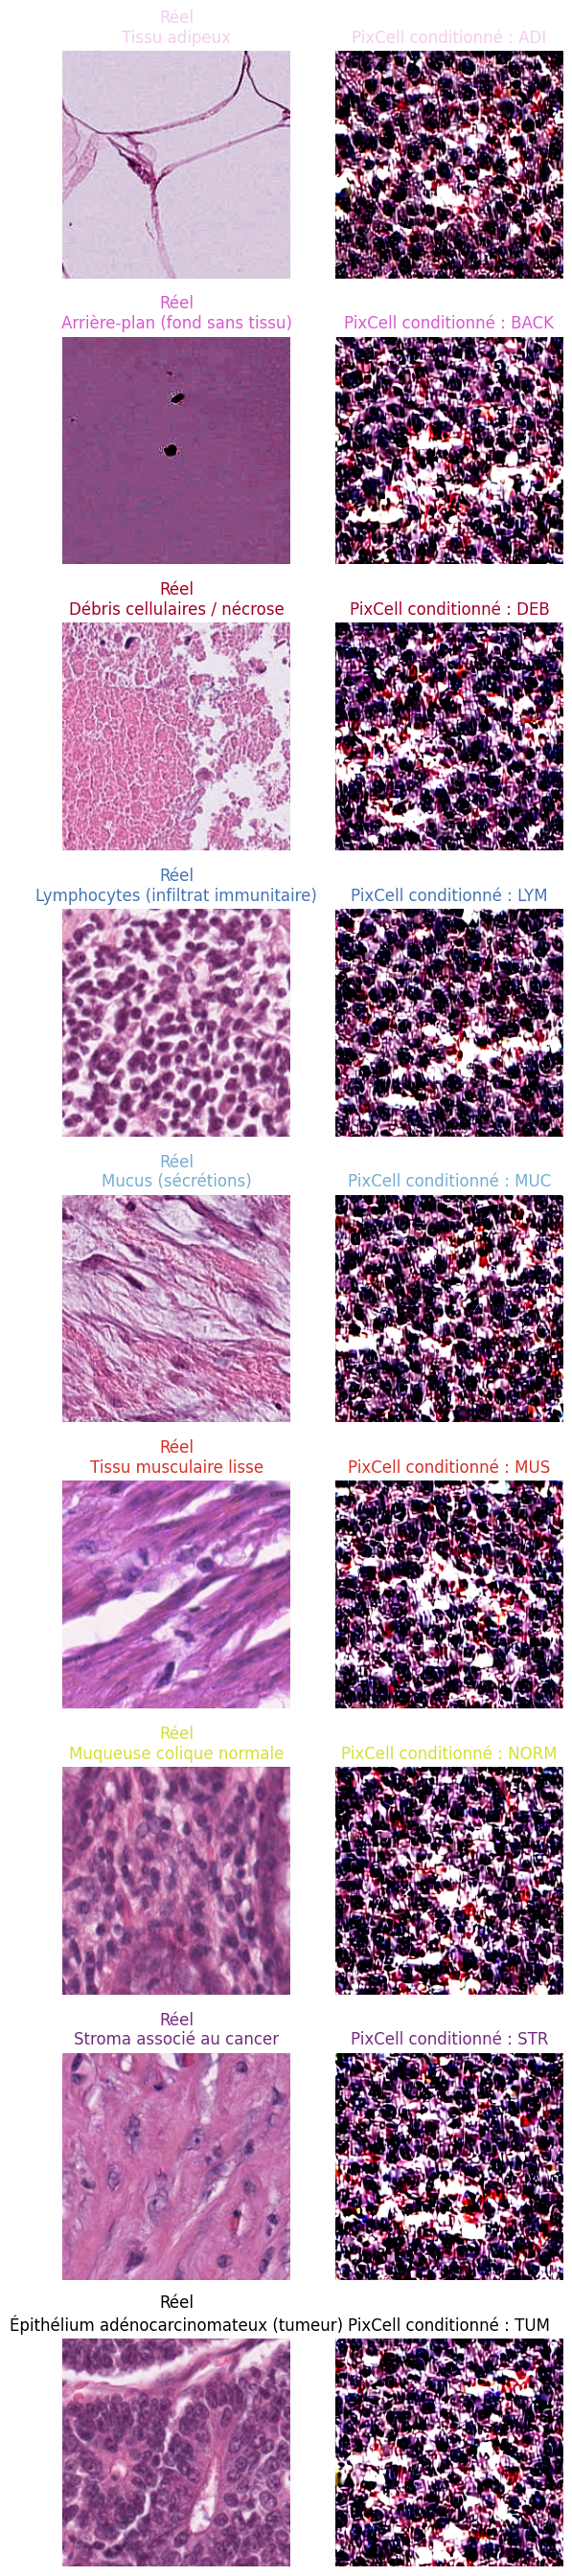

In [16]:
# --- CELL 10B (corrigée, autonome) : Vérif du conditionnement PixCell par prototypes UNI ---
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch, random



# Libellés & couleurs
from utils.class_mappings import class_labels, class_colors

print("🎯 Test de génération par classe via prototypes UNI (sans adapter)")

# petite fonction locale pour échantillonner une vraie tuile d'une classe donnée
def get_random_sample_by_class_local(ds, class_name):
    ci = ds.class_to_idx[class_name]
    paths = ds.paths_by_class[ci]
    path = random.choice(paths)
    img = ds._resize(Image.open(path).convert("RGB"))
    return img, ci, path

classes = list(train_ds.class_to_idx.keys())
n_classes = len(classes)
print(f"Classes détectées : {classes}")

# --- Boucle de génération multiclasse (dtype-safe + hook) ---
ref_weight = pipe256.transformer.pos_embed.proj.weight
PIPE_DTYPE = ref_weight.dtype         # typiquement torch.float16
PIPE_DEV   = ref_weight.device

imgs_real, imgs_fake = [], []

for cname in classes:
    # 1️⃣ Prototype UNI (1536) → [1,1,1536] fp16 sur le bon device
    proto_uni = PROTOS[cname].unsqueeze(0).unsqueeze(1).to(device=PIPE_DEV, dtype=PIPE_DTYPE)
    uncond    = torch.zeros_like(proto_uni)

    # 2️⃣ Injection du vecteur UNI pour le hook
    pipe256._uni_cond = proto_uni  # lu par le hook juste avant le forward

    # 3️⃣ Génération PixCell conditionnée
    try:
        out = pipe256(
            num_inference_steps=20,
            guidance_scale=1.5,
            height=256, width=256,
            output_type="pil",
            return_dict=True,
            uni_embeds=proto_uni,              # conservé pour compat
            negative_uni_embeds=uncond,
        ).images[0]
    except Exception as e:
        print(f"⚠️ Erreur pour la classe {cname}: {e}")
        continue

    imgs_fake.append(out)

    # 4️⃣ Vraie tuile de la même classe (pour comparaison visuelle)
    img_real, _, _ = get_random_sample_by_class_local(train_ds, cname)
    imgs_real.append(img_real)

print("✅ Générations terminées.")


# 4) Affichage (réel vs génération), avec libellés/couleurs
ncols = 2
fig, axes = plt.subplots(n_classes, ncols, figsize=(6, 3*n_classes))

for i, cname in enumerate(classes):
    label_full = class_labels.get(cname, cname)
    color_hex = class_colors.get(cname, "#000000")

    axes[i,0].imshow(imgs_real[i]); axes[i,0].axis("off")
    axes[i,0].set_title(f"Réel\n{label_full}", color=color_hex)

    axes[i,1].imshow(imgs_fake[i]); axes[i,1].axis("off")
    axes[i,1].set_title(f"PixCell conditionné : {cname}", color=color_hex)

plt.tight_layout()
plt.show()


In [17]:
# --- CELL 10C : Patch de conditionnement UNI -> AdaLN (expérimental et réversible) ---
import types, torch, torch.nn.functional as F

def patch_pixcell_conditioning(pipe, alpha=0.6):
    """
    Active un conditionnement visible à partir de uni_embeds en modifiant légèrement
    l'embedding AdaLN. Réversible via unpatch_pixcell_conditioning().

    - alpha : intensité du décalage injecté (0.3–1.0 ; commence à 0.6)
    """
    # On récupère le module déjà patché pour la signature:
    adaln   = pipe.transformer.adaln_single
    emb_mod = adaln.emb

    # Sauvegarde du forward original (déjà fait plus haut, mais on isole proprement ici)
    if not hasattr(emb_mod, "_forward_orig_condpatch"):
        emb_mod._forward_orig_condpatch = emb_mod.forward

    def _forward_condpatched(self, *f_args, **f_kwargs):
        """
        1) Appel du forward original (qui produit l'embedding AdaLN)
        2) Si un uni_cond a été déposé dans pipe._uni_cond, on injecte un delta
           dépendant de ce vecteur UNI (classe) dans l'embedding.
        """
        out = self._forward_orig_condpatch(*f_args, **f_kwargs)  # [B, E]
        # Récupérer le tenseur de conditionnement si présent
        uni = getattr(pipe, "_uni_cond", None)  # attendu [B,1,1536] fp16
        if uni is None:
            return out
        try:
            # Normaliser et projeter "à la volée" vers la bonne dimension
            B, E = out.shape[0], out.shape[-1]
            u = uni.squeeze(1).float()                      # [B,1536] fp32
            u = F.normalize(u, dim=-1)                      # stabilise l'échelle
            # Matrice de projection paresseuse: créée au 1er appel pour matcher E
            if not hasattr(pipe, "_uniW") or pipe._uniW.shape[-1] != E:
                torch.manual_seed(1234)  # reproductible
                pipe._uniW = torch.empty((1536, E), device=out.device, dtype=torch.float32)
                torch.nn.init.orthogonal_(pipe._uniW)
            delta = u @ pipe._uniW                           # [B, E] fp32
            out = out + alpha * delta.to(out.dtype)
            return out
        finally:
            # Important: on consomme une fois et on nettoie pour ne pas polluer d'autres appels
            pipe._uni_cond = None

    # Installation du patch
    emb_mod.forward = types.MethodType(_forward_condpatched, emb_mod)
    pipe._condpatch_alpha = float(alpha)
    print(f"✅ Patch de conditionnement installé (alpha={alpha})")

def unpatch_pixcell_conditioning(pipe):
    """Restaure le forward original de l'embedding AdaLN."""
    emb_mod = pipe.transformer.adaln_single.emb
    if hasattr(emb_mod, "_forward_orig_condpatch"):
        emb_mod.forward = emb_mod._forward_orig_condpatch
        print("↩️  Patch de conditionnement retiré.")
    if hasattr(pipe, "_uniW"): delattr(pipe, "_uniW")
    if hasattr(pipe, "_uni_cond"): delattr(pipe, "_uni_cond")
    if hasattr(pipe, "_condpatch_alpha"): delattr(pipe, "_condpatch_alpha")


In [18]:
# --- CELL 10C-bis : Vérification si le pipeline lit bien les uni_embeds ---
import inspect
src = inspect.getsource(pipe256.__call__)
print("Contient 'uni_embeds' dans le forward ?", "uni_embeds" in src)


Contient 'uni_embeds' dans le forward ? True


In [19]:
# --- CELL 10D : Patch direct du transformer PixCell pour activer le conditionnement UNI ---
import types, torch, torch.nn.functional as F

def patch_pixcell_transformer_conditioning(pipe, alpha=0.7):
    """
    Injecte les embeddings UNI (1536-D) dans le transformer PixCell.
    Fonctionne même si la pipeline ignore `uni_embeds`.
    alpha contrôle l'intensité du conditionnement.
    """
    tr = pipe.transformer
    if hasattr(tr, "_forward_original_condpatch"):
        print("⚠️ Transformer déjà patché.")
        return

    tr._forward_original_condpatch = tr.forward  # sauvegarde

    def forward_patched(self, hidden_states, *args, **kwargs):
        # --- Récupération des embeddings UNI depuis kwargs ---
        uni_embeds = kwargs.get("uni_embeds", None)
        out = self._forward_original_condpatch(hidden_states, *args, **kwargs)

        if uni_embeds is None:
            return out

        # --- Injection du conditionnement ---
        try:
            u = uni_embeds.squeeze(1).float()  # [B,1536]
            u = F.normalize(u, dim=-1)
            B, C, H, W = out.shape
            if not hasattr(self, "_uni_proj") or self._uni_proj.weight.shape[-1] != 1536:
                # Crée une projection vers la dimension interne du transformer
                self._uni_proj = torch.nn.Linear(1536, C, bias=False).to(out.device)
                torch.nn.init.orthogonal_(self._uni_proj.weight)
            cond = self._uni_proj(u).unsqueeze(-1).unsqueeze(-1)  # [B,C,1,1]
            out = out + alpha * cond
        except Exception as e:
            print("⚠️ Patch conditioning error:", e)
        return out

    tr.forward = types.MethodType(forward_patched, tr)
    print(f"✅ Patch de conditionnement actif sur le transformer (alpha={alpha})")


def unpatch_pixcell_transformer_conditioning(pipe):
    """Restaure le forward original du transformer PixCell."""
    tr = pipe.transformer
    if hasattr(tr, "_forward_original_condpatch"):
        tr.forward = tr._forward_original_condpatch
        delattr(tr, "_forward_original_condpatch")
        if hasattr(tr, "_uni_proj"): delattr(tr, "_uni_proj")
        print("↩️ Patch de conditionnement retiré.")
    else:
        print("ℹ️ Aucun patch trouvé.")


💾 Adapter sauvegardé → /workspace/outputs/adapters/adapter_uni_pixcell.pt
🧩 Image de démonstration : TUM (/workspace/data/NCT-CRC-HE-100K/TUM/TUM-EYINTNHI.tif)
🎨 Génération avant adaptation...


  0%|          | 0/15 [00:00<?, ?it/s]

🎨 Génération après adaptation...


  0%|          | 0/15 [00:00<?, ?it/s]

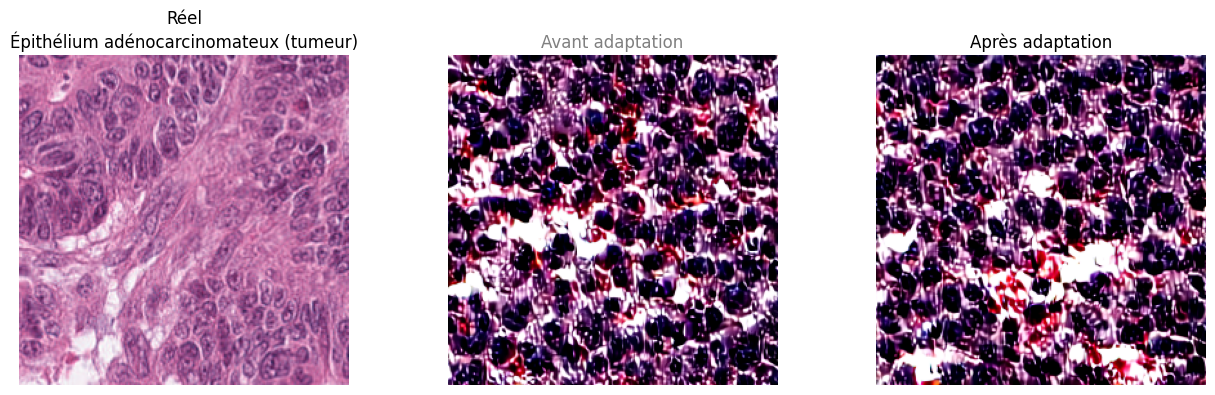

In [20]:
# --- CELL 11 (dtype-safe + hook) : Sauvegarde + Visualisation avant/après ---
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# === Sauvegarde du modèle ===
ADAPTER_PATH = OUTPUT_DIR / "adapters" / "adapter_uni_pixcell.pt"
ADAPTER_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(ADAPTER.state_dict(), ADAPTER_PATH)
print(f"💾 Adapter sauvegardé → {ADAPTER_PATH}")

if USE_LORA and len(LORA_PARAMS) > 0:
    LORA_PATH = OUTPUT_DIR / "adapters" / "lora_pixcell.pt"
    torch.save({f"param_{i}": p for i, p in enumerate(LORA_PARAMS)}, LORA_PATH)
    print(f"💾 LoRA sauvegardées → {LORA_PATH}")

# === Chargement des mappings lisibles ===
from utils.class_mappings import class_labels, make_idx_mappings
idx_to_name, idx_to_color, _ = make_idx_mappings(train_ds.class_to_idx)

# --- Fonction de sélection sécurisée par classe ---
def get_random_sample_by_class(ds, class_name):
    ci = ds.class_to_idx[class_name]
    paths = ds.paths_by_class[ci]
    path = random.choice(paths)
    img = ds._resize(Image.open(path).convert("RGB"))
    return img, ci, path

# === Récup dtype & device du transformer (référence de vérité) ===
ref_weight = pipe256.transformer.pos_embed.proj.weight
PIPE_DTYPE = ref_weight.dtype          # typiquement torch.float16
PIPE_DEV   = ref_weight.device

# === Sélection d'une classe ===
cls_demo = "TUM"   # 🔄 change ici pour tester une autre classe
img_demo, ci_demo, path_demo = get_random_sample_by_class(train_ds, cls_demo)
print(f"🧩 Image de démonstration : {cls_demo} ({path_demo})")

# Prépare le batch d'entrée pour UNI
x_demo = train_ds._to_tensor(img_demo).unsqueeze(0).to(PIPE_DEV)

# === Prépare les embeddings AVANT adaptation (mêmes dtypes que la pipeline) ===
with torch.no_grad():
    e_uni_before = uni_embed_from_tensor(x_demo).detach().clone().to(dtype=torch.float32, device=PIPE_DEV)  # [1,1536]
    uni_tok_before = e_uni_before.unsqueeze(1).to(dtype=PIPE_DTYPE, device=PIPE_DEV)                        # [1,1,1536] fp16
    uncond_tok     = torch.zeros_like(uni_tok_before)                                                       # [1,1,1536] fp16

# === Génération AVANT adaptation (hook + dtypes cohérents) ===
print("🎨 Génération avant adaptation...")
pipe256._uni_cond = uni_tok_before     # le hook lit ceci; même dtype & device
img_before = pipe256(
    num_inference_steps=15,
    guidance_scale=1.5,
    height=256, width=256,
    output_type="pil",
    return_dict=True,
    uni_embeds=uni_tok_before,          # cohérent avec PIPE_DTYPE
    negative_uni_embeds=uncond_tok,
).images[0]

# === Génération APRÈS adaptation ===
print("🎨 Génération après adaptation...")

with torch.no_grad():
    e_uni_after = uni_embed_from_tensor(x_demo).detach().clone().to(dtype=torch.float32, device=PIPE_DEV)   # [1,1536]
    # L'adapter travaille en fp32 ; sa sortie ne sert que pour du debug ici (pas utilisée par la pipeline publique)
    cond128 = ADAPTER(e_uni_after).to(dtype=torch.float32, device=PIPE_DEV)                                 # [1,128]
    uni_tok_after = e_uni_after.unsqueeze(1).to(dtype=PIPE_DTYPE, device=PIPE_DEV)                          # [1,1,1536] fp16

pipe256._uni_cond = uni_tok_after
img_after = pipe256(
    num_inference_steps=15,
    guidance_scale=1.5,
    height=256, width=256,
    output_type="pil",
    return_dict=True,
    uni_embeds=uni_tok_after,
    negative_uni_embeds=torch.zeros_like(uni_tok_after),
).images[0]

# === Affichage comparatif coloré ===
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

color_hex = idx_to_color[ci_demo]
label_full = class_labels[cls_demo]

ax[0].imshow(np.asarray(img_demo))
ax[0].set_title(f"Réel\n{label_full}", color=color_hex)
ax[1].imshow(img_before)
ax[1].set_title("Avant adaptation", color="gray")
ax[2].imshow(img_after)
ax[2].set_title("Après adaptation", color=color_hex)
for a in ax:
    a.axis("off")

plt.tight_layout()
plt.show()
